# 5.3 ロジスティック回帰モデル(logistic regression)

In [16]:
# パッケージの読み込み
using Distributions, PyPlot, LinearAlgebra

In [2]:
function set_options(ax, xlabel, ylabel, title;
                     grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
    return
end

set_options (generic function with 1 method)

## 5.3.1 生成過程

In [3]:
# シグモイド関数を定義
sig(x) = 1/(1+exp(-x))

function generate_logistic(X, μ₁, μ₂, σ₁, σ₂)
    w₁ = rand(Normal(μ₁, σ₁))
    w₂ = rand(Normal(μ₂, σ₂))
    f(x) = sig(w₁ * x + w₂)
    Y = rand.(Bernoulli.(f.(X)))
    Y, f, w₁, w₂
end

generate_logistic (generic function with 1 method)

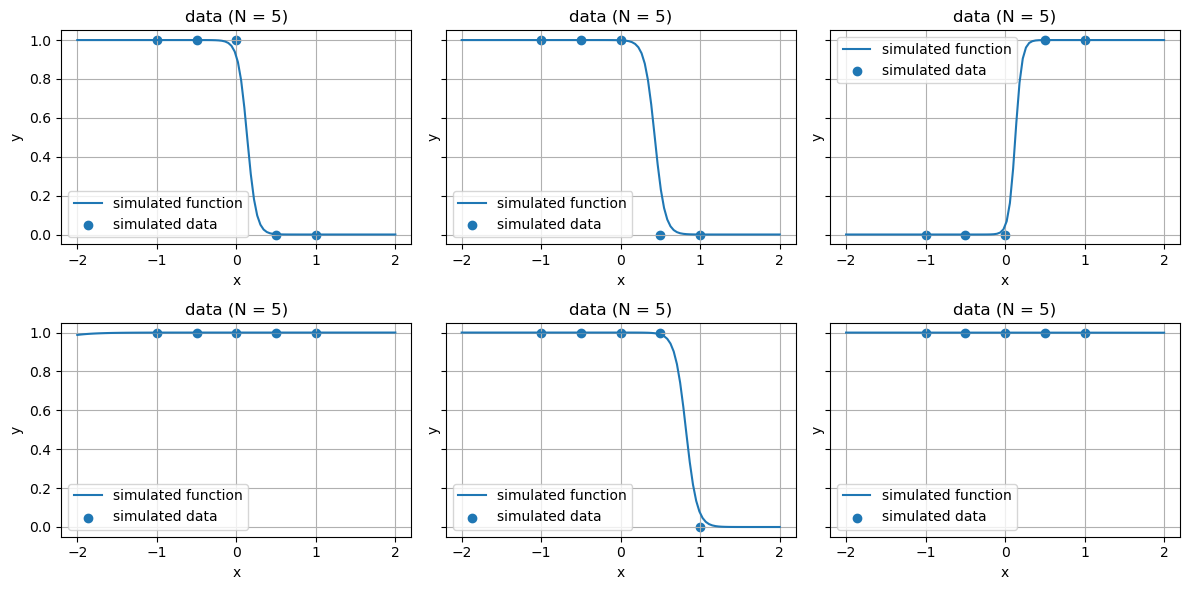

In [4]:
# あらかじめ与えるパラメータと入力集合X
μ₁ = 0.0
μ₂ = 0.0
σ₁ = 10.0
σ₂ = 10.0
X = [-1.0, -0.5, 0, 0.5, 1.0]

# 可視化する範囲
xs = range(-2, 2, length=100)

fig, axes = subplots(2, 3, sharey=true, figsize=(12,6))
for ax in axes
    # 関数f, 出力Yの生成
    Y, f, w₁, w₂ = generate_logistic(X, μ₁, μ₂, σ₁, σ₂)
    
    # 生成された直線とYのプロット
    ax.plot(xs, f.(xs), label="simulated function")
    ax.scatter(X, Y, label="simulated data")
    
    set_options(ax, "x", "y", "data (N = $(length(X)))", legend=true)
end

tight_layout()

## 5.3.2 伝承サンプリング

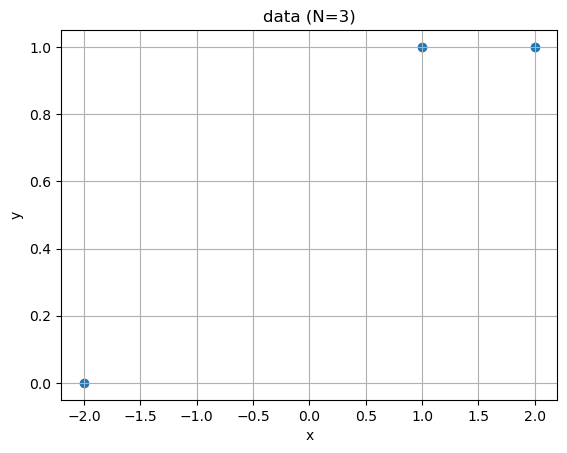

In [5]:
# 入力データセット
X_obs = [-2, 1, 2]

# 出力データセット
Y_obs = Bool.([0, 1, 1])

# 散布図で可視化
fig, ax = subplots()
ax.scatter(X_obs, Y_obs)
set_options(ax, "x", "y", "data (N=$(length(X_obs)))")

In [6]:
# 最大サンプリング数
maxiter = 10_000

# パラメータ保存用
param_posterior = Vector{Tuple{Float64, Float64}}()

for i in 1:maxiter
    # 関数f, 出力Yの生成
    Y, f, w₁, w₂ = generate_logistic(X_obs, μ₁, μ₂, σ₁, σ₂)
    
    # 観測データと一致していれば、そのときのパラメータwを保存
    Y == Y_obs && push!(param_posterior, (w₁, w₂))
end

# サンプルを受容
acceptance_rate = length(param_posterior) / maxiter
println("acceptance rate = $(acceptance_rate)")

acceptance rate = 0.3038


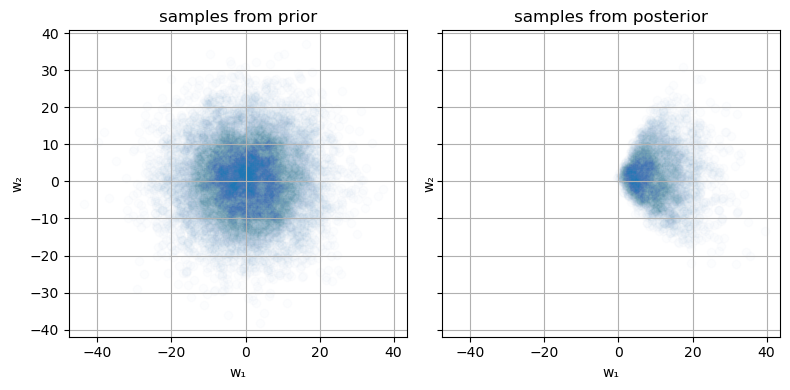

In [7]:
# パラメータ抽出用の関数
unzip(a) = map(x -> getfield.(a, x), fieldnames(eltype(a)))

# 事前分布からのサンプル(10,000組)
param_prior = [generate_logistic(X, μ₁, μ₂, σ₁, σ₂)[3:4] for i in 1:10_000]
w₁_prior, w₂_prior = unzip(param_prior)

# 事後分布からのサンプル
w₁_posterior, w₂_posterior = unzip(param_posterior)

fig, axes = subplots(1, 2, sharex=true, sharey=true, figsize=(8, 4))

# 事前分布
axes[1].scatter(w₁_prior, w₂_prior, alpha=0.01)
set_options(axes[1], "w₁", "w₂", "samples from prior")

# 事後分布
axes[2].scatter(w₁_posterior, w₂_posterior, alpha=0.01)
set_options(axes[2], "w₁", "w₂", "samples from posterior")

tight_layout()

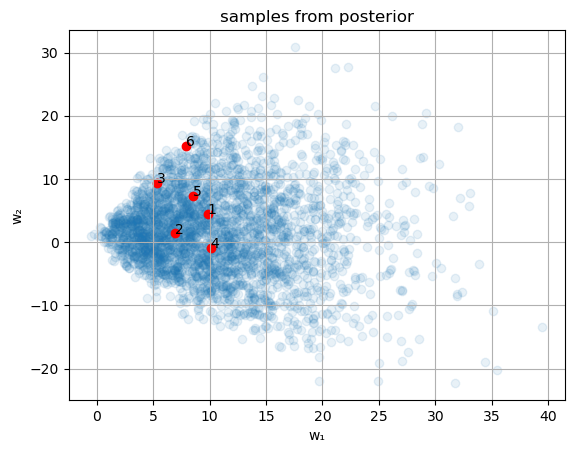

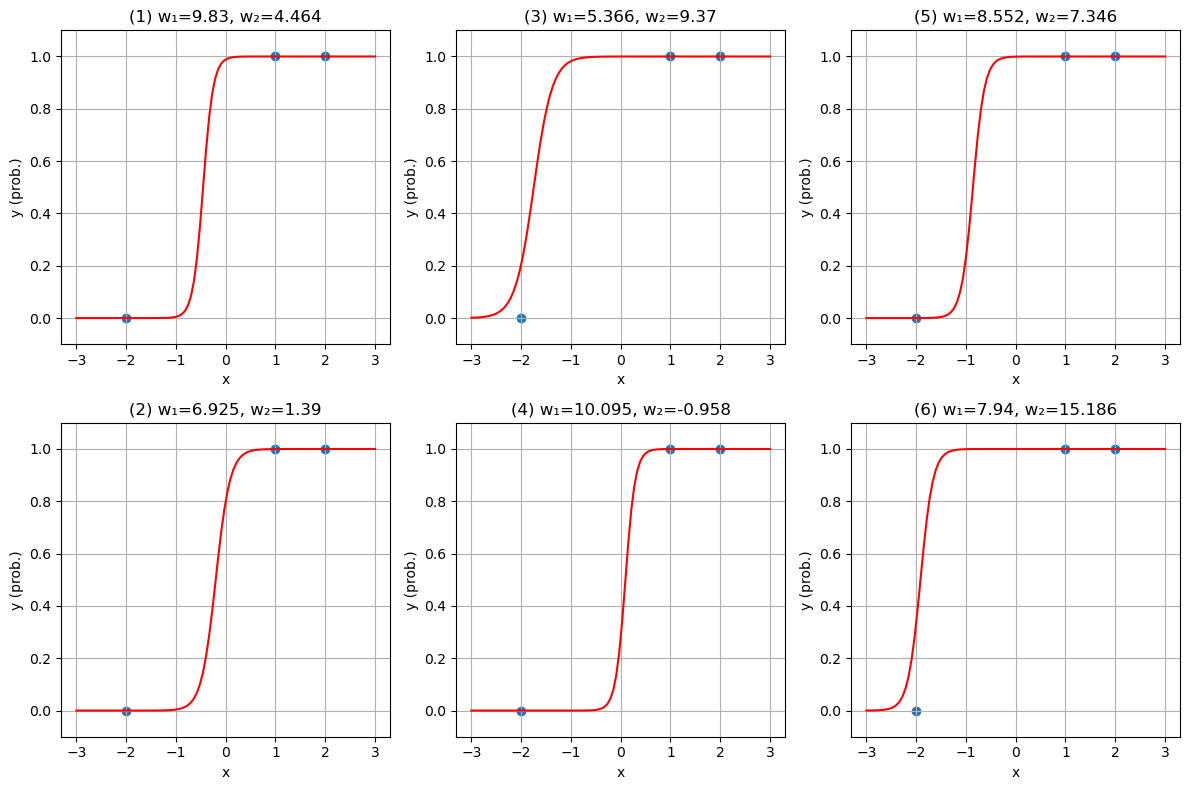

In [8]:
# 関数を可視化する範囲
xs = range(-3, 3, length=100)

fig, ax = subplots()
ax.scatter(w₁_posterior, w₂_posterior, alpha=0.1)
set_options(ax, "w₁", "w₂", "samples from posterior")

fig, axes = subplots(2, 3, figsize=(12,8))
for i in eachindex(axes)
    # 関数を可視化するためのwを1つ適当に選択
    j = round(Int, length(param_posterior)*rand()) + 1
    w₁, w₂ = param_posterior[j]
    
    # 選択されたw
    ax.scatter(w₁, w₂, color="r")
    ax.text(w₁, w₂, i)
    
    # 対応する関数のプロット
    f(x) = sig(w₁*x + w₂)
    axes[i].plot(xs, f.(xs), "r")
    
    # 観測データのプロット
    axes[i].scatter(X_obs, Y_obs)
    
    axes[i].set_ylim([-0.1, 1.1])
    set_options(axes[i], "x", "y (prob.)", "($(i)) w₁=$(round(w₁, digits=3)), w₂=$(round(w₂, digits=3))")
end

tight_layout()

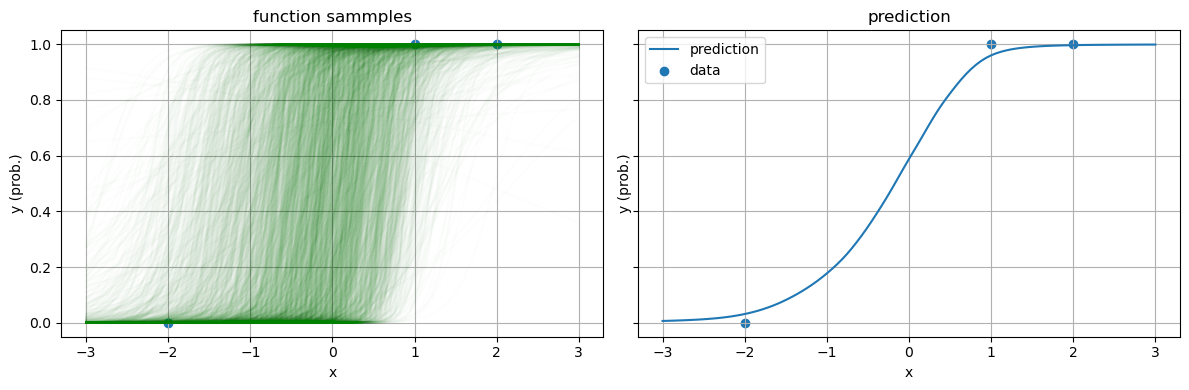

In [9]:
fig, axes = subplots(1, 2, sharey=true, figsize=(12,4))

fs = []
for (i, param) in enumerate(param_posterior)
    # 1サンプル分のパラメータ
    w₁, w₂ = param
    
    # 1サンプル分の予測関数
    f(x) = sig(w₁*x + w₂)
    axes[1].plot(xs, f.(xs), "g", alpha=0.01)
    
    push!(fs, f.(xs))
end
axes[1].scatter(X_obs, Y_obs)
set_options(axes[1], "x", "y (prob.)", "function sammples")

# 予測確率
axes[2].plot(xs, mean(fs), label="prediction")
axes[2].scatter(X_obs, Y_obs, label="data")
set_options(axes[2], "x", "y (prob.)", "prediction", legend=true)

tight_layout()

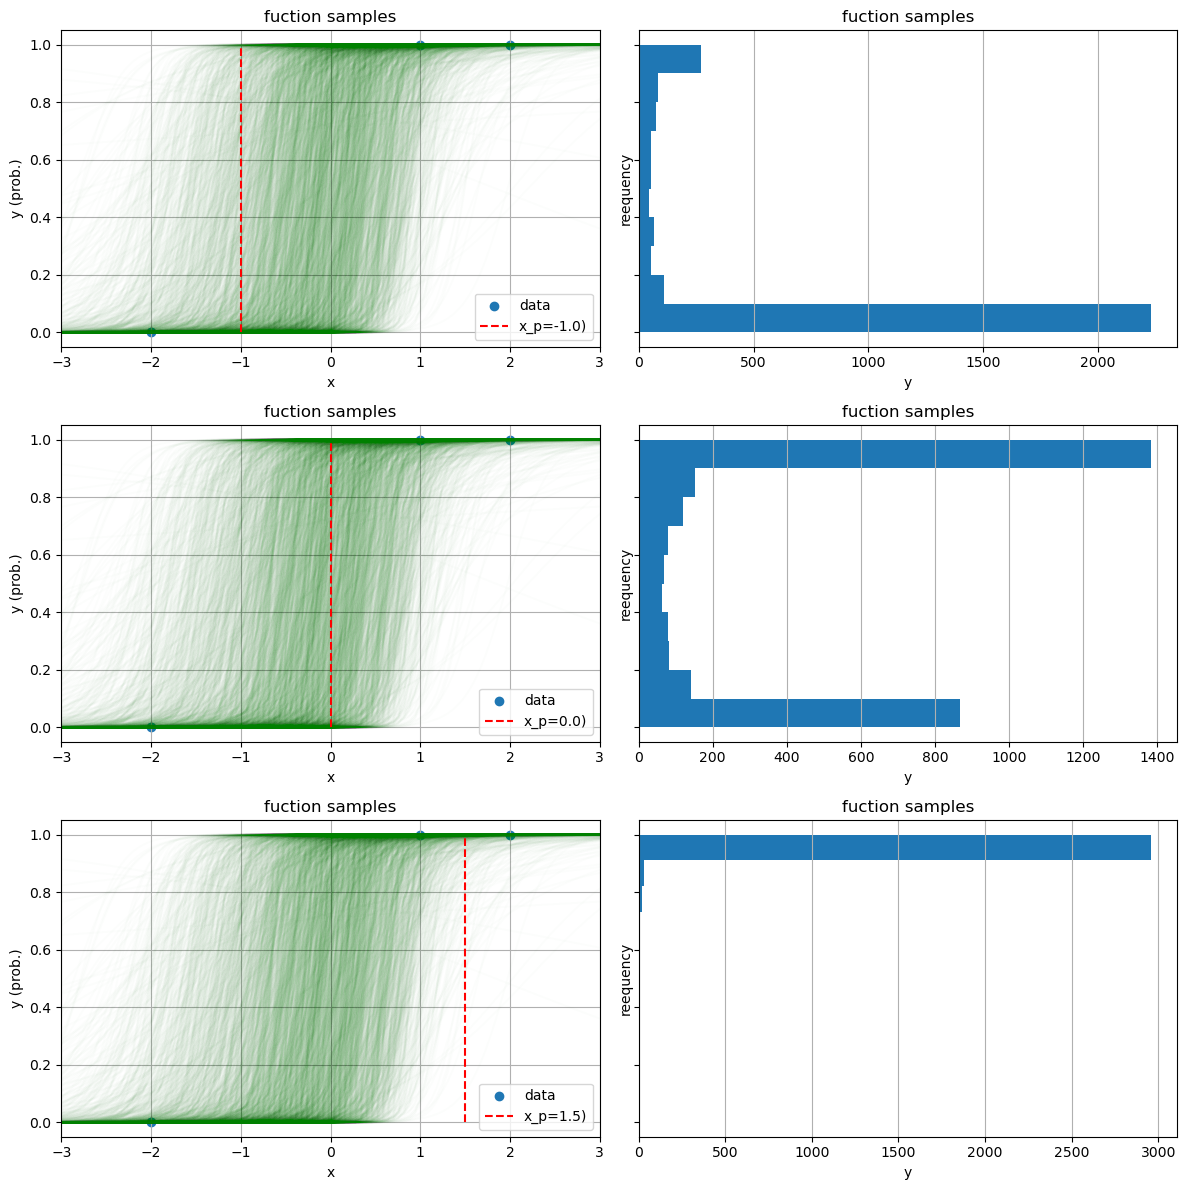

In [10]:
# 予測対象の点候補
x_list = [-1.0, 0.0, 1.5]

fig_num = length(x_list)
fig, axes = subplots(fig_num, 2, sharey=true, figsize=(12,4*fig_num))
for (j, x) in enumerate(x_list)
    # パラメータごとに関数を可視化
    for (i, param) in enumerate(param_posterior)
        w₁, w₂ = param
        f(x) = sig(w₁*x + w₂)
        axes[j].plot(xs, f.(xs), "g", alpha=0.01)
    end

    # 観測データ
    axes[j].scatter(X_obs, Y_obs, label="data")
    
    # 候補点のx座標
    axes[j].plot([x, x], [0, 1], "r--", label="x_p=$(x))")

    axes[j].set_xlim(extrema(xs))
    set_options(axes[j], "x", "y (prob.)", "fuction samples")
    axes[j].legend(loc="lower right")

    # 点xにおける関数値（確率値）をヒストグラムとして可視化
    probs = [sig(param[1]*x+param[2]) for param in param_posterior]
    axes[j+fig_num].hist(probs, orientation="horizontal")
    set_options(axes[j+fig_num], "y", "reequency", "fuction samples", grid=false)
    axes[j+fig_num].grid(axis="x")
end

tight_layout()

## 5.3.3 数値積分

In [11]:
# 同時分布p(Y, w|X)
p_joint(X, Y, w₁, w₂) = prod(pdf.(Bernoulli.(sig.(w₁.*X .+ w₂)), Y)) * pdf(Normal(μ₁, σ₁), w₁) * pdf(Normal(μ₂, σ₂), w₂)

# 数値積分
function approx_integration_2D(w_range, p)
    Δ = w_range[2] - w_range[1]
    (X, Y) -> sum([p(X, Y, w₁, w₂) * Δ^2 for w₁ in w_range, w₂ in w_range])
end

# μの積分範囲
w_range = range(-30, 30, length=100)

# 数値積分の実行
p_marginal = approx_integration_2D(w_range, p_joint)
p_marginal(X_obs, Y_obs)

0.2966829565005522

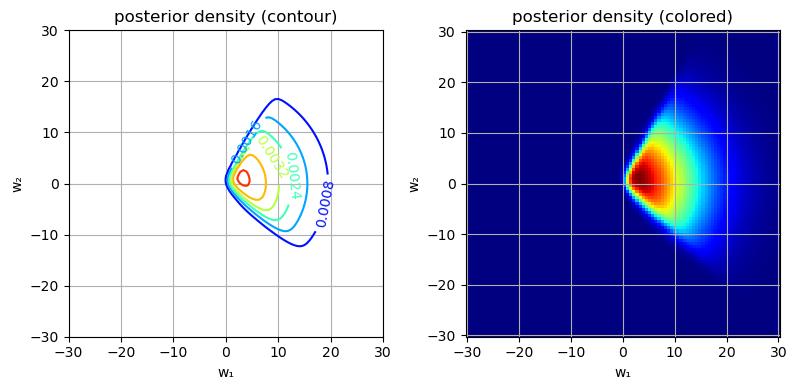

In [12]:
# 事後分布の計算
w_posterior = [p_joint(X_obs, Y_obs, w₁, w₂) for w₁ in w_range, w₂ in w_range] ./ p_marginal(X_obs, Y_obs)

# 事後分布の描画
fig, axes = subplots(1, 2, figsize=(8,4))

# 等高線図
cs = axes[1].contour(w_range, w_range, w_posterior' .+ eps(), cmap="jet")
axes[1].clabel(cs, inline=true)
set_options(axes[1], "w₁", "w₂", "posterior density (contour)")

# カラーメッシュ
xgrid = repeat(w_range', length(w_range), 1)
ygrid = repeat(w_range, 1, length(w_range))
axes[2].pcolormesh(xgrid, ygrid, w_posterior', cmap="jet", shading="auto")
set_options(axes[2], "w₁", "w₂", "posterior density (colored)")

tight_layout()

In [13]:
function approx_predictive(w_posterior, w_range, p)
    Δ = w_range[2] - w_range[1]
    (x, y) -> sum([p(x, y, w₁, w₂) * w_posterior[i,j] * Δ^2 
                for (i,w₁) in enumerate(w_range), 
                    (j,w₂) in enumerate(w_range)])
end

approx_predictive (generic function with 1 method)

In [14]:
p_likelihood(xₚ, yₚ, w₁, w₂) = pdf(Bernoulli(sig(w₁*xₚ + w₂)), yₚ)
p_predictive = approx_predictive(w_posterior, w_range, p_likelihood)

#18 (generic function with 1 method)

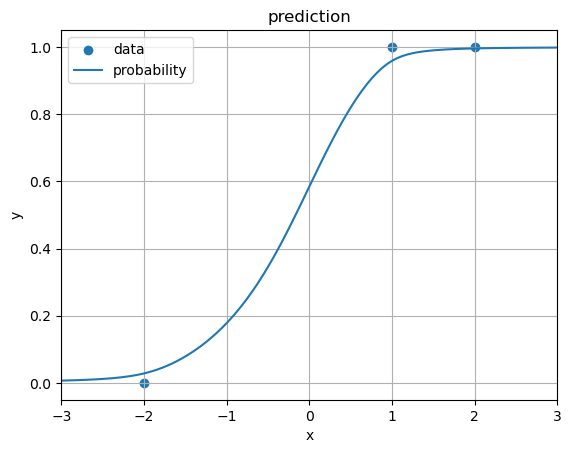

In [15]:
# 関数を可視化する範囲
xs = range(-3, 3, length=100)

fig, ax = subplots()
ax.scatter(X_obs, Y_obs, label="data")
ax.plot(xs, p_predictive.(xs, 1), label="probability")
ax.set_xlim([-3, 3])
set_options(ax, "x", "y", "prediction", legend=true)